# SENG 550 Final Project

Group Members:
- Amanada Nguyen
- Dat Lam
- Luke Son
- Tom Altankhuyag
- Tommy Tran

RDD-Based MLib API doc (python): [rdd-BASED](https://spark.apache.org/docs/latest/api/python/reference/pyspark.mllib.html)

# Setup


In [ ]:
!apt-get install openjdk-8-jdk-headless -qq > /dev/null
!wget https://dlcdn.apache.org/spark/spark-3.3.3/spark-3.3.3-bin-hadoop3.tgz
!tar -xvf spark-3.3.3-bin-hadoop3.tgz
!pip install findspark
!pip install pyspark
import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
os.environ["SPARK_HOME"] = "/content/spark-3.3.3-bin-hadoop3"

--2023-12-12 02:07:32--  https://dlcdn.apache.org/spark/spark-3.3.3/spark-3.3.3-bin-hadoop3.tgz
Resolving dlcdn.apache.org (dlcdn.apache.org)... 151.101.2.132, 2a04:4e42::644
Connecting to dlcdn.apache.org (dlcdn.apache.org)|151.101.2.132|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 299426263 (286M) [application/x-gzip]
Saving to: ‘spark-3.3.3-bin-hadoop3.tgz’

spark-3.3.3-bin-had 100%[===================>] 285.55M   231MB/s    in 1.2s    

2023-12-12 02:07:34 (231 MB/s) - ‘spark-3.3.3-bin-hadoop3.tgz’ saved [299426263/299426263]

spark-3.3.3-bin-hadoop3/
spark-3.3.3-bin-hadoop3/LICENSE
spark-3.3.3-bin-hadoop3/NOTICE
spark-3.3.3-bin-hadoop3/R/
spark-3.3.3-bin-hadoop3/R/lib/
spark-3.3.3-bin-hadoop3/R/lib/SparkR/
spark-3.3.3-bin-hadoop3/R/lib/SparkR/DESCRIPTION
spark-3.3.3-bin-hadoop3/R/lib/SparkR/INDEX
spark-3.3.3-bin-hadoop3/R/lib/SparkR/Meta/
spark-3.3.3-bin-hadoop3/R/lib/SparkR/Meta/Rd.rds
spark-3.3.3-bin-hadoop3/R/lib/SparkR/Meta/features.rds
spark-3.3.3

In [ ]:
import findspark
findspark.init()

import pyspark
sc = pyspark.SparkContext(appName="someName")

In [ ]:
import os.path
baseDir = os.path.join('.')
inputPath1 = os.path.join('/content/train.csv')
fileName1 = os.path.join(baseDir, inputPath1)

trainRDD = sc.textFile(fileName1, 8)

print(trainRDD)

/content/train.csv MapPartitionsRDD[1] at textFile at NativeMethodAccessorImpl.java:0


### Setup smoke test

In [ ]:
trainPoints = trainRDD.count()
print(trainPoints)

1458645


In [ ]:
sampleTrain = trainRDD.take(2)
print(sampleTrain[0])
print(sampleTrain[1])

id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,trip_duration
id2875421,2,2016-03-14 17:24:55,2016-03-14 17:32:30,1,-73.982154846191406,40.767936706542969,-73.964630126953125,40.765602111816406,N,455


### DATA FIELDS - [INDEX]
```
id - 0
vendor_id - 1
pickup_datetime - 2
dropoff_datetime - 3
passenger_count - 4
pickup_longitude - 5
pickup_latitude - 6
dropoff_longitude - 7
dropoff_latitude - 8
store_and_fwd_flag - 9
trip_duration - 10
```
Notes:
- **duration** - measured in seconds.
- **datetime format** - `year-month-day hour-min-sec` (24 hour)
- **store_and_fwd_flag** - This flag indicates whether the trip record was held in vehicle memory before sending to the vendor because the vehicle did not have a connection to the server - **Y**=store and forward; **N**=not a store and forward trip

### Field Extractors


In [ ]:
def extractFields(rdd):
  recordFields = rdd.split(',')
  # vendor id, [id, pickup_datetime,trip_duration ,pickup_longitude, pickup_latitude, dropoff_longitude, dropoff_latitude]
  return (recordFields[1], (recordFields[0],recordFields[2], recordFields[10],recordFields[5], recordFields[6],recordFields[7], recordFields[8]))

### Filters

In [ ]:
def filterHeaderRow(rdd):
  recordFields = rdd.split(',')
  if recordFields[0] == u'id':
    return False
  else:
    return True

In [ ]:
def filterPassengers(rdd):
  recordFields = rdd.split(',')
  # Only take trips with passengers greater than 0
  if int(recordFields[4]) > 0:
    return True
  else:
    return False

In [ ]:
def filterTripDuration(rdd):
  recordFields = rdd.split(',')
  # Only take trips with duration less then 166 minutes
  if int(recordFields[10]) > 0 and int(recordFields[10]) < 10000:
    return True
  else:
    return False

### map and field smoke testing

In [ ]:
headlessTrainRDD = trainRDD.filter(filterHeaderRow)
filteredPassengersTrainRDD = headlessTrainRDD.filter(filterPassengers)
filteredTrainRDD = filteredPassengersTrainRDD.filter(filterTripDuration)
pairedTrainRDD = trainRDD.map(extractFields)

sampleNonFiltered = pairedTrainRDD.take(2)
print(sampleNonFiltered[0])
print(sampleNonFiltered[1])

('vendor_id', ('id', 'pickup_datetime', 'trip_duration', 'pickup_longitude', 'pickup_latitude', 'dropoff_longitude', 'dropoff_latitude'))
('2', ('id2875421', '2016-03-14 17:24:55', '455', '-73.982154846191406', '40.767936706542969', '-73.964630126953125', '40.765602111816406'))


# Data Extrapolation

### LabeledPoint

In [ ]:
from pyspark.mllib.regression import LabeledPoint
import numpy as np
def createLabeledPoints(rdd):
  """
    rdd: Should be in format (label, (feature1, feature2,...))
  """
  recordFields = rdd.split(',')
  point = LabeledPoint(recordFields[0], recordFields[1:])
  return point

### Regression data extractors

In [ ]:
def regressionDataExtractor(rdd):
  """
  Input:
    rdd: ('vendor_id', ('id', 'pickup_datetime', 'trip_duration', 'pickup_longitude', 'pickup_latitude', 'dropoff_longitude', 'dropoff_latitude'))
  Output:
    data: 'trip_duration, pickup_longitude, pickup_latitude, dropoff_longitude, dropoff_latitude'
  """
  features = rdd[1]

  data = features[2]+','+features[3]+','+features[4]+','+features[5]+','+features[6]
  return data

In [ ]:
from math import radians, sin, cos, sqrt, atan2
from datetime import datetime

def calcDistance(lat1, lon1, lat2, lon2):
    # Convert latitude and longitude from degrees to radians
    lat1, lon1, lat2, lon2 = map(radians, [float(lat1), float(lon1), float(lat2), float(lon2)])

    # Haversine formula
    dlat = lat2 - lat1
    dlon = lon2 - lon1
    a = sin(dlat / 2) ** 2 + cos(lat1) * cos(lat2) * sin(dlon / 2) ** 2
    c = 2 * atan2(sqrt(a), sqrt(1 - a))

    # Radius of the Earth in kilometers
    R = 6371.0

    # Calculate the distance
    distance = R * c

    return distance


def regressionDataExtractorWithDistance(rdd):
  """
  Input:
    rdd: ('id', ('vendor_id', 'pickup_datetime', 'trip_duration', 'pickup_longitude', 'pickup_latitude', 'dropoff_longitude', 'dropoff_latitude'))
  Output:
    data: 'trip_duration, distance, pick_hour, pick_day'
  """
  features = rdd[1]
  distance = calcDistance(features[4], features[3], features[6], features[5])

  pickupDatetime = datetime.strptime(features[1], "%Y-%m-%d %H:%M:%S")
  pickupHour = pickupDatetime.hour
  pickupDay = pickupDatetime.weekday() + 1

  data = features[2] + ',' + str(distance) + ',' + str(pickupHour) + ',' + str(pickupDay)
  return data

In [ ]:
def regressionDataExtractorWithAll(rdd):
  """
  Input:
    rdd: ('id', ('vendor_id', 'pickup_datetime', 'trip_duration', 'pickup_longitude', 'pickup_latitude', 'dropoff_longitude', 'dropoff_latitude'))
  Output:
    data: 'trip_duration, pickup_longitude, pickup_latitude, dropoff_longitude, dropoff_latitude, pick_hour, pick_day'
  """
  features = rdd[1]

  pickupDatetime = datetime.strptime(features[1], "%Y-%m-%d %H:%M:%S")
  pickupHour = pickupDatetime.hour
  pickupDay = pickupDatetime.weekday() + 1

  data = features[2]+','+features[3]+','+features[4]+','+features[5]+','+features[6]+','+ str(pickupHour)+','+ str(pickupDay)
  return data

### Error calculators

In [ ]:
import math

In [ ]:
def squaredError(label, prediction):
    """Calculates the the squared error for a single prediction.

    Args:
        label (float): The correct value for this observation.
        prediction (float): The predicted value for this observation.

    Returns:
        float: The difference between the `label` and `prediction` squared.
    """
    sqrError = (label-prediction)*(label-prediction)
    return sqrError

def calcRMSE(labelsAndPreds):
    """Calculates the root mean squared error for an `RDD` of (label, prediction) tuples.

    Args:
        labelsAndPred (RDD of (float, float)): An `RDD` consisting of (label, prediction) tuples.

    Returns:
        float: The square root of the mean of the squared errors.
    """
    sqrSum = labelsAndPreds.map(lambda s: squaredError(s[0],s[1])).sum()
    return math.sqrt(sqrSum/labelsAndPreds.count())

### Normalizization helpers

In [ ]:
def getNormalizedRDD(nonNormalizedRDD):
    """Normalizes the features of the LabeldPoints contained in nonNormalizedRDD.

    Args:
        nonNormalizedRDD - RDD containing non-normalized features

    Returns:
        returnRDD: RDD containing normalized features
    """


    meanList = list()
    stdevList = list()
    numFeatures = len(nonNormalizedRDD.take(1)[0].features)
    for i in range(0,numFeatures):
        featureRDD = nonNormalizedRDD.map(lambda lp: lp.features[i])
        featureMean = featureRDD.mean()
        featureStdev = featureRDD.stdev()
        meanList.insert(i,featureMean)
        stdevList.insert(i,featureStdev)
    global broadcastMean
    broadcastMean = sc.broadcast(meanList)
    global broadcastStdev
    broadcastStdev = sc.broadcast(stdevList)
    returnRDD = nonNormalizedRDD.map(normalizeFeatures)
    return returnRDD

def normalizeFeatures(lp):
    """Normalizes features in the LabeledPoint object lp.

    Args:
        lp - LabeledPoint object

    Returns:
        LabeledPoint: The object contains the label and the normalized features
    """
    normalizedFeatures = list()
    for i in range(0,len(lp.features)):
        feature = (lp.features[i]-broadcastMean.value[i])/broadcastStdev.value[i]
        normalizedFeatures.insert(i,feature)
    return LabeledPoint(lp.label, normalizedFeatures)

# Predicting trip durations


## Setup


In [ ]:
from pyspark.mllib.linalg import DenseVector
from pyspark.mllib.regression import LinearRegressionWithSGD
from pyspark.mllib.tree import RandomForest

In [ ]:
# Values to use when training the linear regression model
numIters = 500  # iterations
alpha = 1.0  # step
miniBatchFrac = 1.0  # miniBatchFraction
reg = 1e-1  # regParam
regType = 'l2'  # regType
useIntercept = True  # intercept

### RDD with Location-based features

finalTrainingData format: (trip_duration, 'pickup_longitude, pickup_latitude, dropoff_longitude, dropoff_latitude')

In [ ]:
headlessTrainRDD = trainRDD.filter(filterHeaderRow)
filteredPassengersTrainRDD = headlessTrainRDD.filter(filterPassengers)
filteredTrainRDD = filteredPassengersTrainRDD.filter(filterTripDuration)
filteredPairedTrainRDD = filteredTrainRDD.map(extractFields)

extractedDataRDD = filteredPairedTrainRDD.map(regressionDataExtractor)


labeledTrainDataRDD = extractedDataRDD.map(createLabeledPoints)

labelPoint = labeledTrainDataRDD.take(1)
print(labelPoint[0].label,labelPoint[0].features)
print(labelPoint)
# Normalize
normalizedTrainingData = getNormalizedRDD(labeledTrainDataRDD)
normalizedTrainingData.cache()

labelPoint = normalizedTrainingData.take(1)
print(labelPoint[0].label,labelPoint[0].features)

455.0 [-73.9821548461914,40.76793670654297,-73.96463012695312,40.765602111816406]
[LabeledPoint(455.0, [-73.9821548461914,40.76793670654297,-73.96463012695312,40.765602111816406])]
455.0 [-0.1221704389187316,0.5175474936099073,0.12438690676292093,0.3845381070373702]


In [ ]:
weights = [.8, .2]
seed = 101
finalTrainingData, finalTestingData = normalizedTrainingData.randomSplit(weights, seed)
finalTrainingData.cache()
finalTestingData.cache()

PythonRDD[18] at RDD at PythonRDD.scala:53

### RDD with Distance-based features
finalTrainingDataWithDistance Format: (trip_duration, 'trip_distance, pickupHour, pickupDate')

In [ ]:
headlessTrainRDD = trainRDD.filter(filterHeaderRow)
filteredPassengersTrainRDD = headlessTrainRDD.filter(filterPassengers)
filteredTrainRDD = filteredPassengersTrainRDD.filter(filterTripDuration)
filteredPairedTrainRDD = filteredTrainRDD.map(extractFields)

extractedDataWithDistanceRDD = filteredPairedTrainRDD.map(regressionDataExtractorWithDistance)
labeledTrainDataWithDistanceRDD = extractedDataWithDistanceRDD.map(createLabeledPoints)

labelPoint = labeledTrainDataWithDistanceRDD.take(1)
print(labelPoint[0].label,labelPoint[0].features)

normalizedTrainingDataWithDistance = getNormalizedRDD(labeledTrainDataWithDistanceRDD)
normalizedTrainingDataWithDistance.cache()

labelPoint = normalizedTrainingDataWithDistance.take(1)
print(labelPoint[0].label,labelPoint[0].features)

455.0 [1.4985207796469109,17.0,1.0]
455.0 [-0.45230956110933845,0.5302763656443267,-1.5608685716218864]


In [ ]:
weights = [.8, .2]
seed = 101
finalTrainingDataWithDistance, finalTestingDataWithDistance = normalizedTrainingDataWithDistance.randomSplit(weights, seed)
finalTrainingDataWithDistance.cache()
finalTestingDataWithDistance.cache()

PythonRDD[30] at RDD at PythonRDD.scala:53

### Combined RDD
finalTrainingDataWithAll Format: (trip_duration, (pickup_longitude, pickup_latitude, dropoff_longitude, dropoff_latitude, pick_hour, pick_day))

In [ ]:
extractedDataWithAllRDD = filteredPairedTrainRDD.map(regressionDataExtractorWithAll)
labeledTrainDataWithAllRDD = extractedDataWithAllRDD.map(createLabeledPoints)

labelPoint = labeledTrainDataWithAllRDD.take(1)
print(labelPoint[0].label,labelPoint[0].features)

normalizedTrainingDataWithAll = getNormalizedRDD(labeledTrainDataWithAllRDD)
normalizedTrainingDataWithAll.cache()

labelPoint = normalizedTrainingDataWithAll.take(1)
print(labelPoint[0].label,labelPoint[0].features)

455.0 [-73.9821548461914,40.76793670654297,-73.96463012695312,40.765602111816406,17.0,1.0]
455.0 [-0.1221704389187316,0.5175474936099073,0.12438690676292093,0.3845381070373702,0.5302763656443267,-1.5608685716218864]


In [ ]:
weights = [.8, .2]
seed = 101
finalTrainingDataWithAll, finalTestingDataWithAll = normalizedTrainingDataWithAll.randomSplit(weights, seed)
finalTrainingDataWithAll.cache()
finalTestingDataWithAll.cache()

PythonRDD[48] at RDD at PythonRDD.scala:53

## Scatter Plot of Duration vs Distance

<ipython-input-26-c99a1aad4d5f>:6: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = get_cmap('YlOrRd')


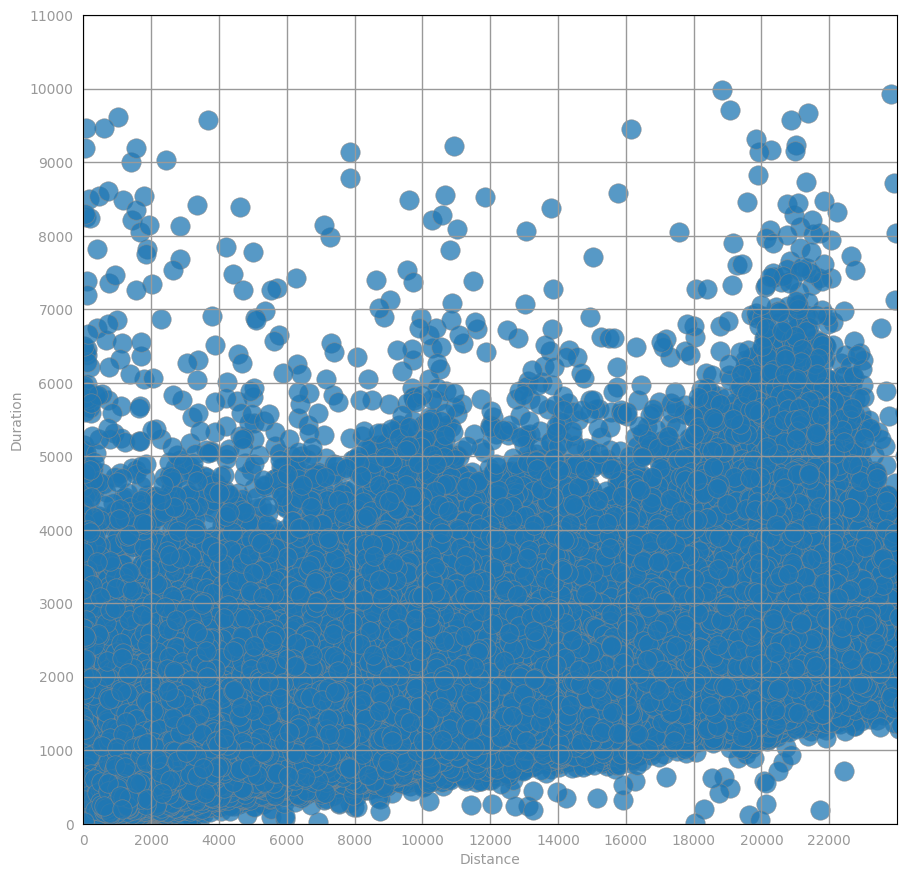

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from matplotlib.colors import ListedColormap, Normalize
from matplotlib.cm import get_cmap

cmap = get_cmap('YlOrRd')

def preparePlot(xticks, yticks, figsize=(10.5, 10.5), hideLabels=False, gridColor='#999999',
                gridWidth=1.0):
    """Template for generating the plot layout."""
    plt.close()
    fig, ax = plt.subplots(figsize=figsize, facecolor='white', edgecolor='white')
    ax.axes.tick_params(labelcolor='#999999', labelsize='10')
    for axis, ticks in [(ax.get_xaxis(), xticks), (ax.get_yaxis(), yticks)]:
        axis.set_ticks_position('none')
        axis.set_ticks(ticks)
        axis.label.set_color('#999999')
        if hideLabels: axis.set_ticklabels([])
    plt.grid(color=gridColor, linewidth=gridWidth, linestyle='-')
    map(lambda position: ax.spines[position].set_visible(False), ['bottom', 'top', 'left', 'right'])
    return fig, ax

duration = np.asarray(labeledTrainDataWithDistanceRDD
                         .map(lambda lp: lp.label)
                         .collect())

distance = np.asarray(labeledTrainDataWithDistanceRDD
                    .map(lambda lp: float(lp.features[0])*1000).collect())

norm = Normalize()

fig, ax = preparePlot(np.arange(0, 24000, 2000), np.arange(0, 12000, 1000))
ax.set_xlim(0, 24000), ax.set_ylim(0, 11000)
plt.scatter(distance, duration, s=14**2, edgecolors='#888888', alpha=0.75, linewidths=.5)
ax.set_xlabel('Distance'), ax.set_ylabel(r'Duration')
pass

## Baseline

### Average

In [ ]:
averageTripDuration = (finalTrainingData.map(lambda point: point.label)).mean()
print(averageTripDuration)

836.2671060705504


### RMSE Average baseline

In [ ]:
labelsAndPredsTest = finalTestingData.map(lambda s: (s.label,averageTripDuration))
rmseTestBaseline = calcRMSE(labelsAndPredsTest)

print('Baseline Test RMSE = {0:.3f}'.format(rmseTestBaseline))

Baseline Test RMSE = 659.504


## Trip train 1 (Linear Regression Using Location)

### Data Extrapolation


In [ ]:
nTrain = finalTrainingData.count()
nTest = finalTestingData.count()

print(nTrain, nTest, nTrain + nTest)
print(normalizedTrainingData.count())

firstPoint = finalTrainingData.take(1)
print(firstPoint[0].label, firstPoint[0].features)


1165215 291247 1456462
1456462
663.0 [-0.09763972599698537,-0.37624606134451466,-0.3687473545322525,-0.575452690538048]


### Model

In [ ]:
firstModel = LinearRegressionWithSGD.train(finalTrainingData,numIters,alpha,miniBatchFrac,initialWeights=None,regParam=reg,regType=regType,intercept=useIntercept)

weightsLR1 = firstModel.weights
interceptLR1 = firstModel.intercept
print(weightsLR1, interceptLR1)

/content/spark-3.3.3-bin-hadoop3/python/pyspark/mllib/regression.py:367: FutureWarning: Deprecated in 2.0.0. Use ml.regression.LinearRegression.
  warnings.warn("Deprecated in 2.0.0. Use ml.regression.LinearRegression.", FutureWarning)


[112.45399691748818,-107.54686091413633,-1.7121893590749753,-66.29820728899497] 760.3749110054289


### Predict & Evaluate

Sample point

In [ ]:
samplePoint = finalTestingData.take(1)[0]
samplePrediction = firstModel.predict(samplePoint.features)
print(samplePrediction)
print(samplePoint.label)

665.26858746308
455.0


Calculate RMSE for all

In [ ]:
realAndPreds = finalTestingData.map(lambda point: (point.label, firstModel.predict(point.features)))

rmseTestLinearReg = calcRMSE(realAndPreds)

print(rmseTestBaseline)
print(rmseTestLinearReg)

659.5035892240167
638.1175229411381


## Trip train 2 (Linear Regression Using Distance)

### Data extrapolation

In [ ]:
nTrain = finalTrainingDataWithDistance.count()
nTest = finalTestingDataWithDistance.count()

print(nTrain, nTest, nTrain + nTest)
print(normalizedTrainingDataWithDistance.count())

firstPoint = finalTrainingDataWithDistance.take(1)
print(firstPoint[0].label, firstPoint[0].features)


1165215 291247 1456462
1456462
663.0 [-0.38076970698634277,-2.12627579160696,1.5097313310310323]


### Model training

In [ ]:
# Data with distance
secondModel = LinearRegressionWithSGD.train(finalTrainingDataWithDistance,numIters,alpha,miniBatchFrac,initialWeights=None,regParam=reg,regType=regType,intercept=useIntercept)

weightsLR2 = secondModel.weights
interceptLR2 = secondModel.intercept
print(weightsLR1, interceptLR1)

[112.45399691748818,-107.54686091413633,-1.7121893590749753,-66.29820728899497] 760.3749110054289


### Predict & Evaluate

Sample point

In [ ]:
samplePoint = finalTestingDataWithDistance.take(1)[0]
samplePrediction = secondModel.predict(samplePoint.features)
print(samplePrediction)

607.878872152907


Calculate RMSE for all

In [ ]:
realAndPreds2 = finalTestingDataWithDistance.map(lambda point: (point.label, secondModel.predict(point.features)))
rmseTestLinearReg2 = calcRMSE(realAndPreds2)

print("Baseline")
print(rmseTestBaseline)
print("Linear Regression")
print(rmseTestLinearReg)
print("Current RMSE")
print(rmseTestLinearReg2)

Baseline
659.5035892240167
Linear Regression
638.1175229411381
Current RMSE
505.23923775895196


## Trip train 3 (Random Forest Using Location)



### Model training

In [ ]:
firstForestModel = RandomForest.trainRegressor(finalTrainingData,{},100,seed=51 )

### Predict & Evaluate

Sample point

In [ ]:
samplePoint = finalTrainingData.take(1)[0]
samplePrediction = firstForestModel.predict(samplePoint.features)
print(samplePrediction)
print(samplePoint.label)

714.2913733160763
663.0


Calculate RMSE for all

In [ ]:
testFeatures = finalTestingData.map(lambda point: point.features)

preds4 = firstForestModel.predict(testFeatures)
labels4 = finalTestingData.map(lambda point: point.label)

print(preds4.count())
print(labels4.count())

realAndPreds4 = labels4.zip(preds4)
rmseTestForestReg = calcRMSE(realAndPreds4)

print("Baseline")
print(rmseTestBaseline)
print("Linear Regressions")
print(rmseTestLinearReg)
print(rmseTestLinearReg2)
print("Current RMSE")
print(rmseTestForestReg)

291247
291247
Baseline
659.5035892240167
Linear Regressions
638.1175229411381
505.23923775895196
Current RMSE
512.136694202527


## Trip train 4 (Random Forst Using Location With More Features)



### Model Training
Using Data from Trip train 1 (Linear Regression Using Location)

In [ ]:
secondForestModel = RandomForest.trainRegressor(finalTrainingDataWithAll,{},100,seed=51 )

### Predict & Evaluate


Sample point

In [ ]:
samplePoint = finalTestingDataWithAll.take(1)[0]
samplePrediction = secondForestModel.predict(samplePoint.features)
print(samplePrediction)
print(samplePoint.label)

739.0233101498958
455.0


Calculate RMSE for all

In [ ]:
testFeatures = finalTestingDataWithAll.map(lambda point: point.features)

preds5 = secondForestModel.predict(testFeatures)
labels5 = finalTestingDataWithAll.map(lambda point: point.label)

realAndPreds5 = labels5.zip(preds5)

# print(realAndPreds4.collect())
rmseTestForestReg2 = calcRMSE(realAndPreds5)

print("Baseline")
print(rmseTestBaseline)
print("Linear Regressions")
print(rmseTestLinearReg)
print(rmseTestLinearReg2)
print("Random Forest")
print(rmseTestForestReg)

print("Current RMSE")
print(rmseTestForestReg2)

Baseline
659.5035892240167
Linear Regressions
638.1175229411381
505.23923775895196
Random Forest
512.136694202527
Current RMSE
516.4020072685283


## Trip train 5 (Random Forest with Higher Polynomials)

### Data Expansion

In [ ]:
from itertools import combinations

def expand_features(label_point):
    features = label_point.features
    expanded_features = []

    # Original features
    for feature in features:
        expanded_features.append(feature)

    # Cross-terms (combinations of 2)
    for pair in combinations(features, 2):
        expanded_features.append(pair[0] * pair[1])

    return LabeledPoint(label_point.label, (expanded_features))

In [ ]:
orderTwoRDD = labeledTrainDataWithAllRDD.map(expand_features)
orderTwoRDD.cache()

labelPoint = orderTwoRDD.take(1)
print(labelPoint[0].label,labelPoint[0].features)

normalizedOrderTwoDataWithAll = getNormalizedRDD(orderTwoRDD)
normalizedOrderTwoDataWithAll.cache()

labelPoint = normalizedOrderTwoDataWithAll.take(1)
print(labelPoint[0].label,labelPoint[0].features)

455.0 [-73.9821548461914,40.76793670654297,-73.96463012695312,40.765602111816406,17.0,1.0,-3016.0998061831924,5472.06271919352,-3015.9270878346288,-1257.696632385254,-73.9821548461914,-3015.3853595384862,1661.9294866986456,693.0549240112305,40.76793670654297,-3015.2126821030397,-1257.3987121582031,-73.96463012695312,693.0152359008789,40.765602111816406,17.0]
455.0 [-0.1221704389187316,0.5175474936099073,0.12438690676292093,0.3845381070373702,0.5302763656443267,-1.5608685716218864,-0.4455209575956783,-0.0010994195700460918,-0.38065076619448907,-0.5305924357483298,1.560785572685089,-0.2624460303776775,0.5232659034689024,0.5314168411457837,-1.5607225497591508,-0.18672225710503718,-0.5299276783026061,1.560931338624383,0.5311836307076371,-1.5607420831648227,-0.9612611276550901]


In [ ]:
weights = [.8, .2]
seed = 101
finalOrderTwoTrainingDataWithAll, finalOrderTwoTestingDataWithAll = normalizedOrderTwoDataWithAll.randomSplit(weights, seed)
finalOrderTwoTrainingDataWithAll.cache()
finalOrderTwoTestingDataWithAll.cache()

PythonRDD[301] at RDD at PythonRDD.scala:53

### Model Training

In [ ]:
thirdForestModel = RandomForest.trainRegressor(finalOrderTwoTrainingDataWithAll,{},100,seed=51 )

### Predict & Evaluate


Sample point

In [ ]:
samplePoint = finalOrderTwoTestingDataWithAll.take(1)[0]
samplePrediction = thirdForestModel.predict(samplePoint.features)
print(samplePrediction)
print(samplePoint.label)

674.6181281087155
455.0


Calculate RMSE for all

In [ ]:
testFeatures = finalOrderTwoTestingDataWithAll.map(lambda point: point.features)

preds6 = thirdForestModel.predict(testFeatures)
labels6 = finalOrderTwoTestingDataWithAll.map(lambda point: point.label)

realAndPreds6 = labels6.zip(preds6)

rmseTestForestReg3 = calcRMSE(realAndPreds6)

print("Baseline")
print(rmseTestBaseline)
print("Linear Regressions")
print(rmseTestLinearReg)
print(rmseTestLinearReg2)
print("Random Forest")
print(rmseTestForestReg)
print(rmseTestForestReg2)

print("Current RMSE")
print(rmseTestForestReg3)

Baseline
659.5035892240167
Linear Regressions
638.1175229411381
505.23923775895196
Random Forest
512.136694202527
516.4020072685283
Current RMSE
481.26008664538364


# Classifying Vendors

##Setup

###Map Function Setup

In [ ]:
# Use headlessTrainRDD for training; filters out the column titles
from pyspark.mllib.classification import LogisticRegressionWithSGD
from pyspark.mllib.linalg import Vectors
from pyspark.mllib.regression import LabeledPoint
from pyspark.mllib.evaluation import MulticlassMetrics
import math
import datetime

date_format = "%Y-%m-%d %H:%M:%S"

# Checking if a string is in datetime format
def is_datetime(datapoint):
  try:
    datetime.datetime.strptime(datapoint, date_format)
    return True
  except ValueError:
    return False

def string_to_timestamp(date_string):
  return datetime.datetime.strptime(date_string, date_format)

###Logistic Regression (Training, Prediction, and Evaluation)

In [ ]:
def VendorLogisticRegression(map_function):
  # Benchmarking model. We use 80% of our data for training and 20% for benchmarking
  headlessTrainRDD = trainRDD.filter(filterHeaderRow)
  filteredPassengersTrainRDD = headlessTrainRDD.filter(filterPassengers)
  filteredTrainRDD = filteredPassengersTrainRDD.filter(filterTripDuration)
  trainingDataRDD, testingDataRDD = filteredTrainRDD.randomSplit([0.8,0.2])

  # TRAINING
  filteredRDD = trainingDataRDD.map(
            lambda line: LabeledPoint(
                    # Spark is 0-indexed, so subtracting 1 here
                    float(float(line.split(',')[1]) - 1), # Vendor ID
                    map_function(line)
            )
        )
  logIters = 500 #number of iterations
  logAlpha = 1.0 #step (default)
  logMiniBatchFraction = 1.0 #miniBatchFraction (default)
  logReg = 1e-2 #regParam (default)
  logRegType = 'l2' #RegType
  logUseIntercept = True # intercept

  lrm = LogisticRegressionWithSGD.train(filteredRDD,logIters,logAlpha,logMiniBatchFraction,initialWeights=None,regParam=logReg,regType=logRegType,intercept=logUseIntercept)

  # PREDICT AND EVALUATE
  prediction = testingDataRDD.map(
                lambda x:
                  (float(lrm.predict(map_function(x))), float(float(x.split(',')[1]) - 1))
                )

  print(prediction.collect())

  print(lrm.weights)
  print(lrm.intercept)

  print("Accuracy: ", MulticlassMetrics(prediction).accuracy * 100 , "%")

  logLabelsAndPreds = headlessTrainRDD.map(lambda line:
                            (float(float(line.split(',')[1]) - 1), # Vendor ID
                            float(lrm.predict(map_function(line))))
                      )
  logRMSEVal = calcRMSE(logLabelsAndPreds)
  print(logLabelsAndPreds.take(1))
  print(logRMSEVal)

##Vendor Train 1 (Logistic Regression using all features)

In [ ]:
def get_all_features(raw_data):
  features = []
  partitioned_data = raw_data.split(',')
  for datapoint in partitioned_data[2:]:
    if is_datetime(datapoint):
      pdatetime = string_to_timestamp(datapoint)
      features.append(pdatetime.hour)
      features.append(pdatetime.weekday() + 1)
    elif datapoint == 'Y':
      features.append(1)
    elif datapoint == 'N':
      features.append(0)
    else:
      features.append(float(datapoint))
  return features

In [ ]:
VendorLogisticRegression(get_all_features)

/content/spark-3.3.3-bin-hadoop3/python/pyspark/mllib/classification.py:395: FutureWarning: Deprecated in 2.0.0. Use ml.classification.LogisticRegression or LogisticRegressionWithLBFGS.
  warnings.warn(
IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)

/content/spark-3.3.3-bin-hadoop3/python/pyspark/sql/context.py:157: FutureWarning: Deprecated in 3.0.0. Use SparkSession.builder.getOrCreate() instead.
  warnings.warn(


Accuracy:  53.26959070766013 %
[(1.0, 1.0)]
0.6819550989007253


##Vendor Train 2 (Logistic Regression on Locations)

In [ ]:
def get_locations(raw_data):
  features = []
  partitioned_data = raw_data.split(',')
  for datapoint in [partitioned_data[5], partitioned_data[6], partitioned_data[7], partitioned_data[8]]:
    features.append(float(datapoint))
  return features

In [ ]:
VendorLogisticRegression(get_locations)

/content/spark-3.3.3-bin-hadoop3/python/pyspark/mllib/classification.py:395: FutureWarning: Deprecated in 2.0.0. Use ml.classification.LogisticRegression or LogisticRegressionWithLBFGS.
  warnings.warn(
IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)

/content/spark-3.3.3-bin-hadoop3/python/pyspark/sql/context.py:157: FutureWarning: Deprecated in 3.0.0. Use SparkSession.builder.getOrCreate() instead.
  warnings.warn(


Accuracy:  53.43967136875874 %
[(1.0, 1.0)]
0.6819455485008581


##Vendor Train 3 (Logistic Regression using store_and_fwd_flag and passenger_count)

In [ ]:
def get_flag_and_passenger(raw_data):
  features = []
  partitioned_data = raw_data.split(',')
  for datapoint in [partitioned_data[4], partitioned_data[9]]:
    if datapoint == 'Y':
      features.append(1)
    elif datapoint == 'N':
      features.append(0)
    else:
      features.append(float(datapoint))
  return features

In [ ]:
VendorLogisticRegression(get_flag_and_passenger)

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



Accuracy:  58.24620040972778 %
[(1.0, 0.0)]
0.6468434202627961


## Baseline Naive approach to RMSE


In [ ]:
#calculating the naive RMSE with a coin flip approach
import random

vendorAndNaive = filteredPairedTrainRDD.map(lambda s: (float(float(s[0])-1), float(random.randint(0,1))))

print("Accuracy: ", MulticlassMetrics(vendorAndNaive).accuracy * 100 , "%")

calcRMSE(vendorAndNaive)

Accuracy:  50.000823914389805 %


0.7071630965043926